<a href="https://colab.research.google.com/github/alikesha/Divar-House-Price-Prediction/blob/main/Divar_House_price_prediction_(Tehran).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1 align="center">House price prediction (Tehran)</h1>
    <h3 align="center">Dataset is crawled from Divar.ir (downloded from kaggle.com)</h3>
    <h4 align="center">Ali Keshavarz</h5>
</div>

####After installing autoviz you might restart your runtime

In [ ]:
pip install autoviz

In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import joblib #for saving data and load
%matplotlib inline


from sklearn.model_selection import train_test_split , cross_val_score, KFold ,GridSearchCV , RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer , IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline , Pipeline
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression , Ridge

from sklearn.metrics import r2_score , mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing data

df = pd.read_csv('tehranhouses.csv')
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [ ]:
# dataframe info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(2)
memory usage: 146.2+ KB


In [ ]:
#dataframe shape

df.shape

(3479, 8)

In [ ]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [ ]:
# remove typing mistakes and changing the datatype for column Area

df['Area'] = df['Area'].apply(lambda x : re.sub(',' , '', x))
df['Area'] = pd.to_numeric(df['Area'] , errors = 'coerce')

In [ ]:
#the Area dtype has been changed

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   int64  
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(3), object(1)
memory usage: 146.2+ KB


In [ ]:
# looking for the missing values

df.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [ ]:
#remove null values

df.dropna(axis = 0 , inplace = True)

In [ ]:
#checking the number of houses which they have Parking or Not

df['Parking'].value_counts()

True     2929
False     527
Name: Parking, dtype: int64

In [ ]:
#normalizing data for better sight

df['Parking'].value_counts(normalize=True)

True     0.847512
False    0.152488
Name: Parking, dtype: float64

In [ ]:
# checking the rooms and parkings

pd.crosstab(df.Parking ,df.Room )

Room,0,1,2,3,4,5
Parking,,,,,,
False,8,243,244,26,1,5
True,2,426,1699,705,69,28


In [ ]:
# number of the unique Address

len(df.Address.unique())

192

In [ ]:
df.Address.unique()

array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Velenjak', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Pakdasht', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Baghestan', 'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Dorous', 'Sadeghieh', 'Chahardangeh', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
       'P

In [ ]:
# average price by number of the Room

df.groupby('Room')['Price'].mean()

Room
0    7.860500e+09
1    1.707481e+09
2    3.330303e+09
3    1.093869e+10
4    2.560033e+10
5    3.373439e+10
Name: Price, dtype: float64

In [ ]:
#remove Price in USD

df = df.drop('Price(USD)' , axis = 1)

In [ ]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,1850000000
1,60,1,True,True,True,Shahran,1850000000
2,79,2,True,True,True,Pardis,550000000
3,95,2,True,True,True,Shahrake Qods,902500000
4,123,2,True,True,True,Shahrake Gharb,7000000000


In [ ]:
df2 = df.copy()

In [ ]:
#changing the format of the column Price

df2.loc[:, "Price"] =df["Price"].apply('تومان{:,.0f}'.format)

In [ ]:
df2.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,"تومان1,850,000,000"
1,60,1,True,True,True,Shahran,"تومان1,850,000,000"
2,79,2,True,True,True,Pardis,"تومان550,000,000"
3,95,2,True,True,True,Shahrake Qods,"تومان902,500,000"
4,123,2,True,True,True,Shahrake Gharb,"تومان7,000,000,000"


#Using PyCaret to have some Overview

In [ ]:
pip install --pre pycaret -q

In [ ]:
from pycaret.regression import *

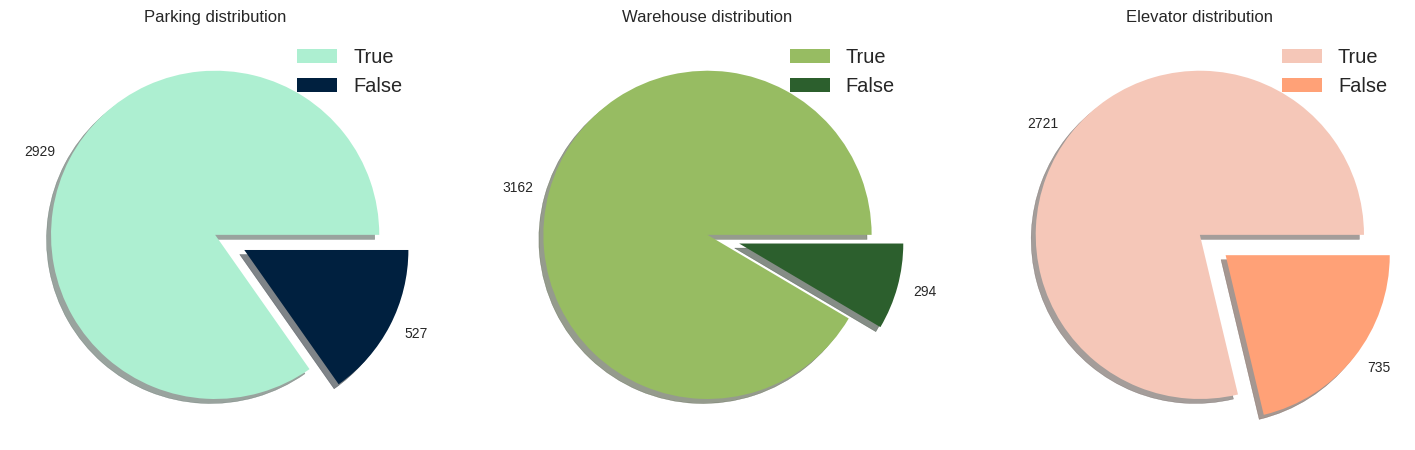

In [ ]:
#showing the distribustion

fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

<Figure size 800x500 with 0 Axes>

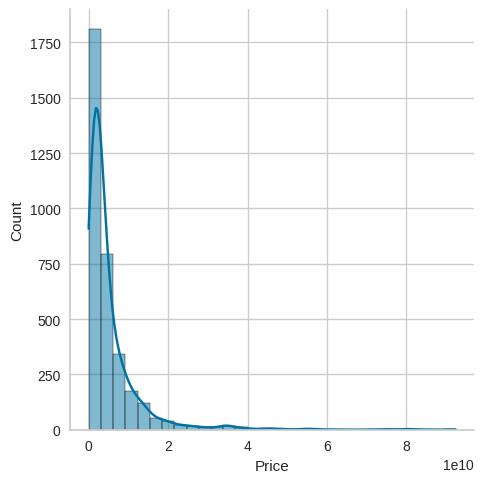

In [ ]:
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True )

In [ ]:
# sorting the 10 most expensive Addresses

df.sort_values('Price',ascending=False)[['Address']].head(10)

,Address
1707,Zaferanieh
1810,Abazar
430,Lavasan
819,Ekhtiarieh
1332,Niavaran
1694,Zafar
3051,Dorous
3107,Tajrish
831,Mahmoudieh
2394,Aqdasieh


In [ ]:
#get some information about model

setup(df , target='Price', session_id = 0 , remove_outliers = True )

,Description,Value
0,Session id,0
1,Target,Price
2,Target type,Regression
3,Original data shape,"(3456, 7)"
4,Transformed data shape,"(3338, 7)"
5,Transformed train set shape,"(2301, 7)"
6,Transformed test set shape,"(1037, 7)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [ ]:
# comparing regression models with each other

best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1434007724.0003,21218202659643994112.0000,4318496957.4774,0.6793,0.4244,0.3905,1.1290
et,Extra Trees Regressor,1439622375.0720,21534578032662478848.0000,4395290167.1372,0.6647,0.4431,0.3948,0.5910
rf,Random Forest Regressor,1444470186.6388,21116955061188726784.0000,4384513692.4090,0.6566,0.4286,0.3954,0.6060
gbr,Gradient Boosting Regressor,1512070523.0194,22153799737965391872.0000,4474610706.9986,0.6494,0.4619,0.4438,0.3170
xgboost,Extreme Gradient Boosting,1445437925.5478,23062669773014380544.0000,4567721208.2627,0.6357,0.4498,0.3669,0.5310
ada,AdaBoost Regressor,2179831775.2463,23683872578462883840.0000,4675459125.1817,0.6109,0.7893,1.1385,0.2600
knn,K Neighbors Regressor,1598806017.6632,26875678903772012544.0000,4854935930.9994,0.6015,0.4680,0.4149,0.2120
dt,Decision Tree Regressor,1695183255.8713,26656243825310867456.0000,4989150885.0454,0.5594,0.5204,0.4342,0.2970
br,Bayesian Ridge,2767526022.1335,41620105951596576768.0000,6184562042.9988,0.3530,0.8161,1.0144,0.3360
omp,Orthogonal Matching Pursuit,2767853746.1715,41618785848328724480.0000,6184506734.8114,0.3530,0.8156,1.0147,0.3000


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# creat our model to have some overview about data
# we can choose any model (R2> 0.6 is better) and ploting that in the next step to see how it works (after removing outliers the result will be different)

my_model = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,936278673.2665,5750235283234718720.0000,2397964821.1003,0.8243,0.5016,0.2442
1,1355973838.2810,9554971156616349696.0000,3091111637.6825,0.7204,0.4591,0.3869
2,1483806771.3058,28522186925070163968.0000,5340616717.6713,0.6230,0.4077,0.2793
3,1128472951.8017,7077575935742768128.0000,2660371390.5661,0.7972,0.5199,0.7137
4,1642593878.2810,20992089444822609920.0000,4581712501.3277,0.6506,0.3909,0.3100
5,1456779668.5620,34934952677696917504.0000,5910579724.3330,0.4687,0.4051,0.3009
6,1769252837.0248,47641342235880554496.0000,6902270802.8504,0.3445,0.5130,0.4090
7,1423305696.3306,12176049451330062336.0000,3489419643.9136,0.5759,0.4815,0.4216
8,1717635261.5537,34471833053386510336.0000,5871271842.9133,0.6289,0.4055,0.2897


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

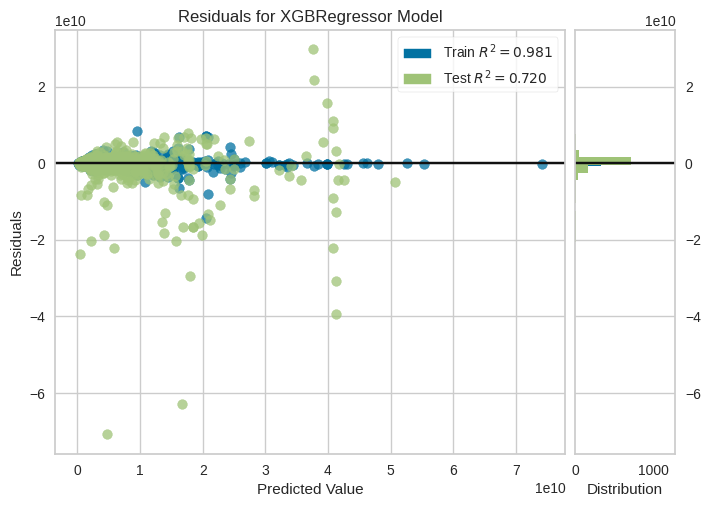

In [ ]:
#plot our model

plot_model(my_model)

In [ ]:
# we can see how our model works

evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

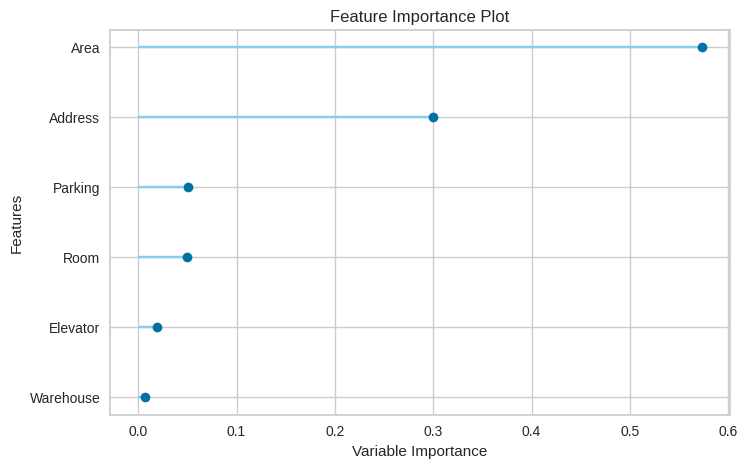

In [ ]:
# to see the Feature Importance

plot_model(estimator = my_model , plot = 'feature')

In [ ]:
df3 = df['Address'].value_counts().copy()
df3 = df3[:8]


Text(0.5, 1.0, 'Number of flats in location')

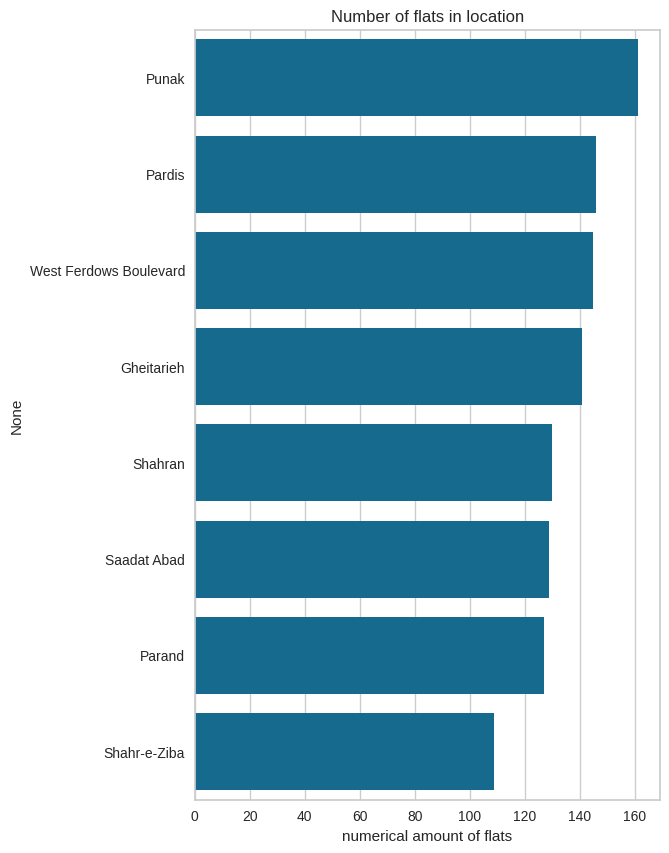

In [ ]:
# how many items do the Addresses have?

fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

#Model Biulding

In [ ]:
##skewness of features

df.skew()

Area         43.827765
Room          0.623938
Parking      -1.934179
Warehouse    -2.975864
Elevator     -1.404947
Price         4.765172
dtype: float64

In [ ]:
# showing the outliers

fig = px.box(df , x = 'Price')
fig.show()

In [ ]:
px.box(df , x = 'Area')

In [ ]:
#creat and using IQR distribution method

def lower_upper(x):
    Q1 = np.percentile(x , 25)
    Q3 = np.percentile(x , 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower , upper

lower_Area , upper_Area = lower_upper(df['Area'])
lower_Price , upper_Price = lower_upper(df['Price'])


print(f"Lower limit for area: {lower_Area:0.2f}")
print(f"Upper limit for area: {upper_Area:0.2f}")
print(f"Lower limit for price: {lower_Price:,}")
print(f"Upper limit for price: {upper_Price:,}")


Lower limit for area: -9.00
Upper limit for area: 199.00
Lower limit for price: -5,450,000,000.0
Upper limit for price: 12,870,000,000.0


In [ ]:
#Area outliers
df[df['Area'] > upper_Area]

,Area,Room,Parking,Warehouse,Elevator,Address,Price
59,215,3,True,True,True,Pakdasht,1750000000
84,300,3,True,True,False,Baghestan,1500000000
160,245,3,True,True,True,Farmanieh,26950000000
167,200,3,True,True,True,Pasdaran,12000000000
174,236,4,True,True,True,Gheitarieh,20000000000
...,...,...,...,...,...,...,...
3254,240,3,True,True,False,Elahieh,34560000000
3264,205,3,True,True,True,Farmanieh,20000000000
3267,220,4,True,True,False,Azarbaijan,15000000000
3334,285,4,True,True,True,Shahrake Gharb,28500000000


In [ ]:
#Price outliers
df[df['Price'] > upper_Price]

,Area,Room,Parking,Warehouse,Elevator,Address,Price
25,160,3,True,True,True,Velenjak,14945000000
102,130,2,True,True,True,Dorous,16900000000
146,150,3,True,True,True,Saadat Abad,20000000000
160,245,3,True,True,True,Farmanieh,26950000000
161,190,3,True,True,True,Kamranieh,24300000000
...,...,...,...,...,...,...,...
3366,197,3,True,True,True,Marzdaran,15563000000
3373,193,3,True,True,True,Kook,13000000000
3394,54,1,True,True,True,West Ferdows Boulevard,22500000003
3438,186,3,True,True,True,Velenjak,15000000000


In [ ]:
#remove outliers

new_df2 = df[df['Area'] < upper_Area]
new_df = new_df2[new_df2['Price'] < upper_Price]

In [ ]:
df.shape

(3456, 7)

In [ ]:
# reseting index after removing outliers
new_df.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {new_df.shape}")

Shape of new dataset: (3090, 7)


In [ ]:
## encoding Address

address_dummy = pd.get_dummies(new_df['Address'])
df_final = new_df.merge(address_dummy, left_index = True, right_index = True)
df_final.drop(columns = 'Address', inplace = True)
df_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,True,True,True,1850000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60,1,True,True,True,1850000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79,2,True,True,True,550000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#creating the train and test

x = df_final.drop(columns = 'Price')
y = df_final['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1234)

print(f"shape of x train: {x_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {x_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2472, 192)
shape of y train: (2472,)
shape of x test: (618, 192)
shape of y train: (618,)


In [ ]:
# make a function to find the best hyperparameters, running time and fit our model to the dataset.

def parameter_finder (model, parameters):

    start = time.time()

    grid = GridSearchCV(model,
                        param_grid = parameters,
                        refit = True,
                        cv = KFold(shuffle = True, random_state = 1),
                        n_jobs = -1)
    grid_fit = grid.fit(x_train, y_train)
    y_train_pred = grid_fit.predict(x_train)
    y_pred = grid_fit.predict(x_test)

    train_score =grid_fit.score(x_train, y_train)
    test_score = grid_fit.score(x_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    model_name = str(model).split('(')[0]

    end = time.time()

    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")


    return train_score, test_score, RMSE , grid_fit

#Deploy The Models To Final Dataset

In [ ]:
#Ridge Regressor

rig = Ridge()

rig_train_score, rig_test_score, rig_RMSE = parameter_finder(rig, {})

The best parameters for Ridge model is: {}
--------------------
(R2 score) in the training set is 86.91% for Ridge model.
(R2 score) in the testing set is 85.02% for Ridge model.
RMSE is 1,094,079,019.1396158 for Ridge model.
--------------------
Runtime of the program is: 2.67


In [ ]:
lr = LinearRegression(n_jobs = -1)

lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})

The best parameters for LinearRegression model is: {}
--------------------
(R2 score) in the training set is 87.44% for LinearRegression model.
(R2 score) in the testing set is -240817672183688593408.00% for LinearRegression model.
RMSE is 4.3860933552861225e+18 for LinearRegression model.
--------------------
Runtime of the program is: 0.41


In [ ]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [300],
            'learning_rate': [0.1,0.05],
            'subsample': [0.75],
            'max_depth': [3,4,5],
              'eta' : [0.2]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, param_xgboost)

The best parameters for XGBRegressor model is: {'eta': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.75}
--------------------
(R2 score) in the training set is 93.69% for XGBRegressor model.
(R2 score) in the testing set is 84.18% for XGBRegressor model.
RMSE is 1,124,153,134.248207 for XGBRegressor model.
--------------------
Runtime of the program is: 130.03


In [ ]:
knr = KNeighborsRegressor(n_jobs = -1)
params = {'n_neighbors' : [ 5,10, 15,20,25 ,21],
          'weights' : ['uniform', 'distance'],
          'p' : [1,2]
}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, params)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
--------------------
(R2 score) in the training set is 98.84% for KNeighborsRegressor model.
(R2 score) in the testing set is 64.65% for KNeighborsRegressor model.
RMSE is 1,680,419,865.5143511 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 18.31


In [ ]:
rf=	RandomForestRegressor(n_jobs = -1)
params = {
        'max_depth': [4,5]
}

rf_train_score, rf_test_score, rf_RMSE = parameter_finder(rf, params)

The best parameters for RandomForestRegressor model is: {'max_depth': 5}
--------------------
(R2 score) in the training set is 68.82% for RandomForestRegressor model.
(R2 score) in the testing set is 64.37% for RandomForestRegressor model.
RMSE is 1,687,154,739.3058832 for RandomForestRegressor model.
--------------------
Runtime of the program is: 6.11


In [ ]:
# comparing models scores

models_score = pd.DataFrame({'Training score': [rig_train_score ,knr_train_score,xgboost_train_score, rf_train_score],
                             'Testing score': [rig_test_score , knr_test_score,xgboost_test_score, rf_test_score],
                             'RMSE': [rig_RMSE ,knr_RMSE,xgboost_RMSE, rf_RMSE]},
                             index = [ 'Ridge' ,'KNeighborsRegressor','XGBoostRegressor' , 'RandomForestRegressor'])

models_score

,Training score,Testing score,RMSE
Ridge,0.869077,0.850159,1.094079e+09
KNeighborsRegressor,0.988417,0.646517,1.680420e+09
XGBoostRegressor,0.936924,0.841808,1.124153e+09
RandomForestRegressor,0.688249,0.643678,1.687155e+09


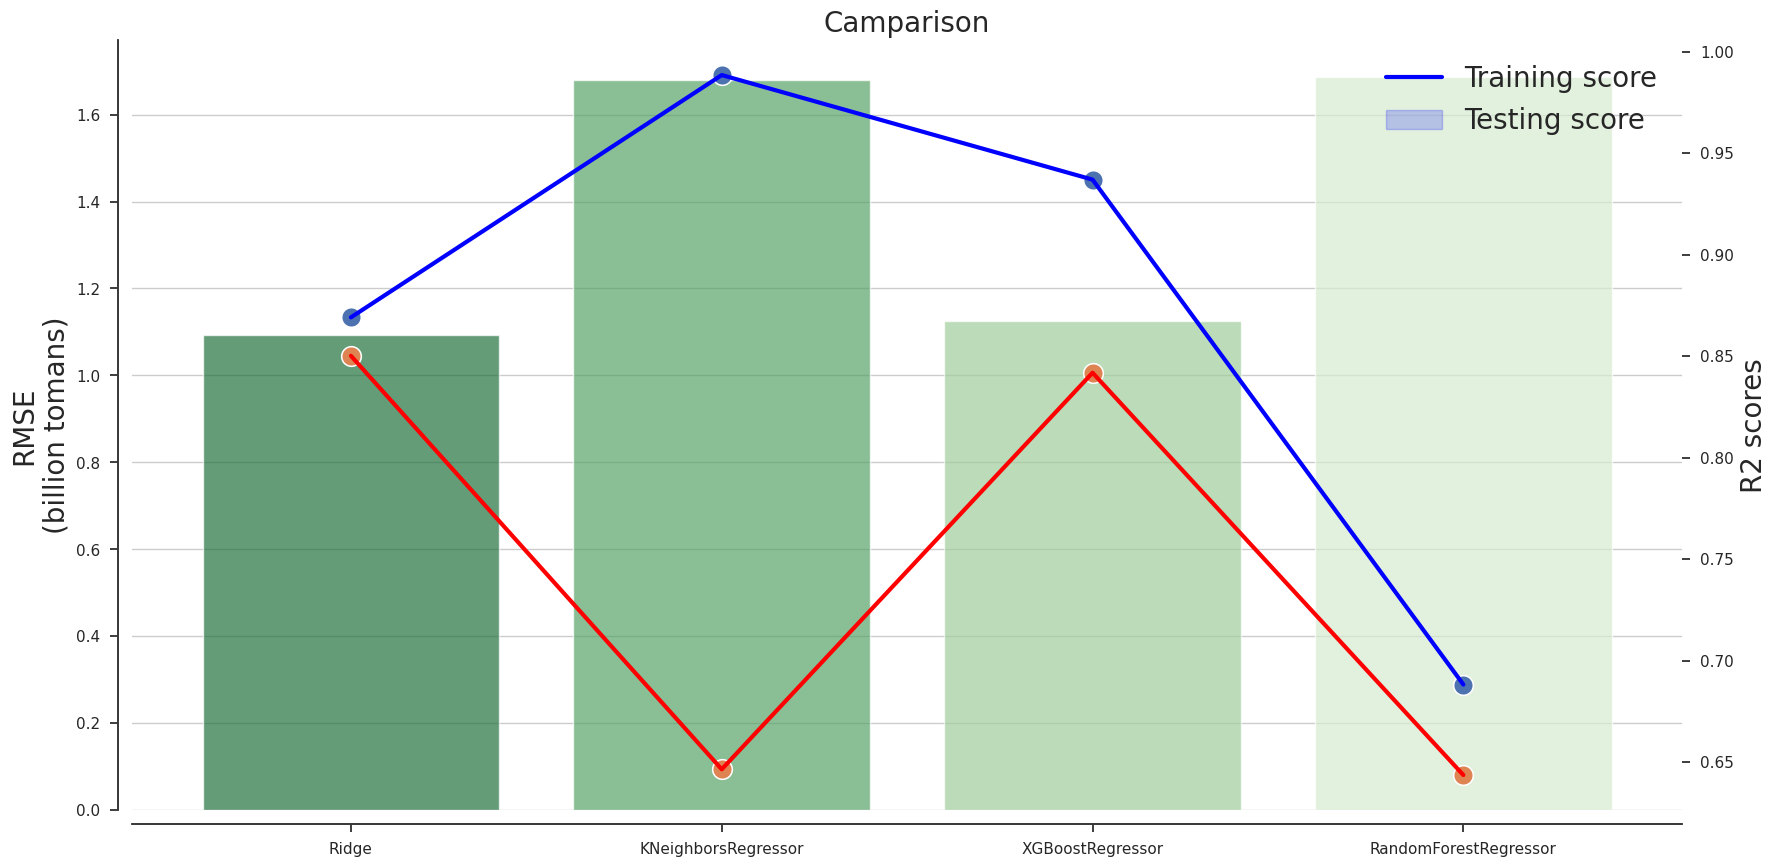

In [ ]:
# comparing the models (by plot)

fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Camparison", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1000000000, alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(billion tomans)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Training score'], linewidth = 3, color = 'blue')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Training score'], s = 200)

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'], linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'], s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = ['Training score', 'Testing score'], fontsize = 20)


sns.despine(offset = 10)

plt.show()

####According to the upper plot, **Ridge Regressor** has better performance

#Save Our Model Using Joblib

In [ ]:
my_model = 'finalized_model.joblib'
joblib.dump(grid_fit, my_model)

['finalized_model.joblib']